In [90]:
# *** PROBLEM 1 *** # 
# a
success_probability = 4/52 
print("a)", success_probability)

# b
def geometric_distribution(p, k): 
    return ((1-p)**(k-1)) * (p)

print("b)", geometric_distribution(success_probability, 4)) 

# c 
import numpy as np

results = np.random.geometric(success_probability, 100000)

print("c)", results)

# d
counter = 0
for trial in results: 
    if (trial == 4):
        counter += 1

print("d)", counter/100000) 

# e 
experimental_results = [15, 6, 13, 14, 1, 10, 5, 2, 11, 3, 
                        32, 8, 4, 4, 7, 20, 13, 12, 8, 4, 
                        14, 15, 4, 37, 3, 2, 6, 12, 11, 5]

print("e)", experimental_results)

# f
counter = 0
for trial in experimental_results: 
    if (trial == 4): 
        counter += 1 

print("f)", counter/30)

#a) 0.07692307692307693
#b) 0.060502083260390055
#c) [5 7 3 ... 4 1 5]
#d) 0.06103
#e) [15, 6, 13, 14, 1, 10, 5, 2, 11, 3, 32, 8, 4, 4, 7, 20, 13, 12, 8, 4, 14, 15, 4, 37, 3, 2, 6, 12, 11, 5]
#f) 0.13333333333333333

a) 0.07692307692307693
b) 0.060502083260390055
c) [ 7  8 14 ...  8 10 40]
d) 0.06127
e) [15, 6, 13, 14, 1, 10, 5, 2, 11, 3, 32, 8, 4, 4, 7, 20, 13, 12, 8, 4, 14, 15, 4, 37, 3, 2, 6, 12, 11, 5]
f) 0.13333333333333333


# g: 

Theoretical Probability: 0.0605 = 6.05% 
Python Sim: 0.0610 = 6.1%
Physical Experiment: 0.13 = 13.3% 

    These results show that the Python simulation and the theoretical probability are very close, 
but the physical experiment resulted in a much higher rate of 4's than expected. This is in part
due to the small sample size, (30 trials vs 100000) and due to the law of large numbers we would 
expect the frequency of 4's to decrease if we increased the number of trials. The physical experiment
also includes a degree of human error when factoring in the shuffling procedure, two different shuffles
could affect the order of the deck in very different ways, so a slight deviation from the expectation 
is not unusual. 

In [376]:
# *** PROBLEM 2 *** #
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import math
import seaborn as sns

In [377]:
# Reading in data
train_df_ori = pd.read_csv('train.csv')
test_df_ori = pd.read_csv('test.csv')

passenger_ids = test_df_ori["PassengerId"]

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()


In [378]:
# Dropping unimportant and poor features 

irrelevant_feats = ['PassengerId', 'Name', 'Cabin', 'Ticket']
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

test_df.to_csv("test_df1.csv", index=False)

In [367]:
# Imputer to fill in the values we can approximate

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
age_fill = imputer.fit_transform(train_df['Age'].values.reshape(-1,1))
train_df['Age'] = age_fill.ravel()
age_fill = imputer.transform(test_df['Age'].values.reshape(-1,1))
test_df['Age'] = age_fill.ravel()

test_df.to_csv("df2.csv", index=False)


In [382]:
print(train_df.head)

numerical_feats = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_feats = ["Sex", "Embarked"]

num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

for column in train_df.columns[1:]: 
    if (column in numerical_feats): 
        fill = num_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = num_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()
    else: 
        fill = cat_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = cat_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()



<bound method NDFrame.head of      Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0           0     3.0    male  22.0      1      0   7.2500        S
1           1     1.0  female  38.0      1      0  71.2833        C
2           1     3.0  female  26.0      0      0   7.9250        S
3           1     1.0  female  35.0      1      0  53.1000        S
4           0     3.0    male  35.0      0      0   8.0500        S
..        ...     ...     ...   ...    ...    ...      ...      ...
886         0     2.0    male  27.0      0      0  13.0000        S
887         1     1.0  female  19.0      0      0  30.0000        S
888         0     3.0  female   NaN      1      2  23.4500        S
889         1     1.0    male  26.0      0      0  30.0000        C
890         0     3.0    male  32.0      0      0   7.7500        Q

[891 rows x 8 columns]>


In [368]:
# Remove specific samples with missing values
for column in train_df.columns[1:]: # Starts at 1 to skip target column only in training set
#specific_samples = ['Embarked']
    train_df.dropna(subset=column, axis=0, inplace=True)
    test_df.dropna(subset=column, axis=0, inplace=True)

test_df.to_csv("df3.csv", index=False)

In [383]:
# One hot encoding 
def dataframe_onehotencoder(encoder, df, columns_names, fit_transform=True):
    '''
    This is a helper function to apply sklearn onehotencoder function
    on multiple columns of a data frame.

    Args:
        encoder: initialized OneHotEncoder
        df: Pandas dataframe with data
        columns_names: names of the columns in dataframe to encode
        fit_transform: True when the encoder is seeing the categorical data for the first time; False otherwise.
    
    Returns:
        dataframe: with one-hot-encoded columns
    '''
    
    # One-hot-encode the columns in column names
    if(fit_transform):
        data = encoder.fit_transform(df[columns_names])
    else:
        data = encoder.transform(df[columns_names])

    # Convert data to a dataframe
    df2 = pd.DataFrame(data, columns=encoder.get_feature_names_out(columns_names), index=df.index)
    
    # Recreate original dataframe
    df3 = pd.concat([df.drop(columns_names, axis=1), df2], axis=1)
    
    # Return
    return df3 


In [384]:
columns_to_encode = ['Sex', 'Embarked']
encoder = OneHotEncoder(drop='first', sparse_output=False) # drops first feature to avoid colinear features
df_OHE = dataframe_onehotencoder(encoder=encoder, df=train_df, columns_names=columns_to_encode, fit_transform=True)
display(df_OHE.head())

# Let's use OneHotEncoding for Later Pipeline example
train_df = dataframe_onehotencoder(encoder=encoder, df=train_df, 
                                   columns_names=columns_to_encode, fit_transform=True)
test_df = dataframe_onehotencoder(encoder=encoder, df=test_df, 
                                  columns_names=columns_to_encode, fit_transform=False)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0
1,1,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0
2,1,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
3,1,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
4,0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,1.0


In [252]:
# Display current dataframe
#display(train_df.head())

# Display scatter plots
#sns.pairplot(train_df, hue='Survived')

In [385]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

In [386]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=train_df, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=test_df, fit_transform=False)

# Display table
#display(train_df2)

# Display seaborn pairplot
#sns.pairplot(train_df2, hue='Survived')

In [387]:
rng1 = np.random.RandomState(seed=45)

y = train_df2['Survived'].values
X = train_df2.iloc[:,1:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)

X_test = test_df2.iloc[:, 1:].values


In [388]:
# SKLEARN MODEL

log_classifier = LogisticRegression(max_iter=1000, random_state=rng1)
log_classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,RandomState(M... 0x1DFAC917240
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [389]:
# Predictions
y_val_pred = log_classifier.predict(X_val)
y_val_probs = log_classifier.predict_proba(X_val)[:, 1]  # probability of "Survived" (class 1)

# Metrics
acc = accuracy_score(y_val, y_val_pred)
loss = log_loss(y_val, y_val_probs)
cm = confusion_matrix(y_val, y_val_pred)

print("Validation Accuracy:", acc)
print("Validation Log Loss (Binary Cross Entropy):", loss)
print("Confusion Matrix:\n", cm)


Validation Accuracy: 0.7985074626865671
Validation Log Loss (Binary Cross Entropy): 0.44009547402646
Confusion Matrix:
 [[75  8]
 [19 32]]


In [390]:
# SCRATCH MODEL

def sigmoid(z): 
    return (1 / (1 + np.exp(-z)))

def initialize_params(m_features, seed=None): 

    if (seed is not None):
        np.random.seed(seed)
    
    w = np.random.rand(m_features, 1)
    b = 0

    return w, b

def forward(X, w, b): 
    z = X.dot(w) + b
    y_hat = sigmoid(z)

    return z, y_hat
     
def compute_cost(y, y_hat, w):
    #Force shapes
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Assumes LogLoss
    eps = 1e-12
    cost = -(np.dot(y.T,np.log(y_hat+eps)) + np.dot(1-y.T,np.log(1-y_hat+eps))) / len(y)

    return np.squeeze(cost)

def compute_gradients(X, y, y_hat, w, reg_lambda=0.0): 
    #Force shapes
    y_hat = y_hat.reshape(-1,1)
    y = y.reshape(-1,1)

    # number of samples
    n = len(y)

    db = (1/n)*np.sum(y_hat-y)
    dw = (1/n)*X.T.dot(y_hat-y)

    return dw, db

def update_params(w, b, dw, db, lr): 
    w = w - lr * dw
    b = b - lr * db

    return w, b

def train(X, y, lr, n_epochs, X_val=None, y_val=None, seed=None): 
    samples, features = X.shape
    w, b = initialize_params(features, seed)

    train_losses = []
    val_losses = []
    
    for i in range(n_epochs): 
        z, y_hat = forward(X, w, b)
        cost = compute_cost(y, y_hat, w)
        train_losses.append(cost)
        dw, db = compute_gradients(X, y, y_hat, w)
        w, b = update_params(w, b, dw, db, lr)

        if (X_val is not None and y_val is not None): 
            z_val, y_hat_val = forward(X_val, w, b)
            val_cost = compute_cost(y_val, y_hat_val, w)
            val_losses.append(val_cost)
    
    return w, b, train_losses, val_losses

def predict_prob(X, w, b): 
    z, y_hat = forward(X, w, b)
    return y_hat

def predict(X, w, b): 
    prob = predict_prob(X, w, b)
    
    return (prob >= 0.5).astype(int)



In [391]:
w, b, training_loss, val_loss  = train(X_train, y_train, .005, 7500, X_val, y_val, 45)

y_val_prob = predict_prob(X_val, w, b)
y_val_prediction = predict(X_val, w, b)

print("Val accuracy:", accuracy_score(y_val, y_val_prediction))
print("Val log loss:", log_loss(y_val, y_val_prob))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_prediction))

Val accuracy: 0.8134328358208955
Val log loss: 0.4989438375217355
Confusion matrix:
 [[78  5]
 [20 31]]


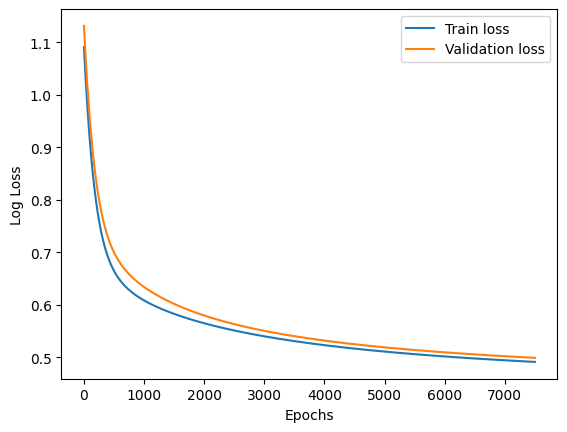

In [392]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [393]:
# TESTING
# Drop Survived so we only keep features
# Predict with your trained model
X_test = test_df2.values
print(X_test.shape)

y_test_pred_scratch = predict(X_test, w, b).flatten()

print(passenger_ids.shape)
print(y_test_pred_scratch.shape)

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_scratch.astype(int)
})

# Save file
submission.to_csv("scratch_submission.csv", index=False)
print("Saved scratchsubmission.csv")

y_test_pred_sk = log_classifier.predict(X_test)

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_sk.astype(int)
})

# Save file
submission.to_csv("sklearn_submission.csv", index=False)
print("Saved sksubmission.csv")

(418, 8)
(418,)
(418,)
Saved scratchsubmission.csv
Saved sksubmission.csv
